In [1]:
import pandas as pd
import numpy as np
import gc; gc.enable()
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [2]:
gp = pd.read_csv('aggregated_features.csv')

In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'])
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'])

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,med_days_up_user,med_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,8.0,2.0,2.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,NaN,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,3.0,1.0,9.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,18.0,3.0,32.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,NaN,NaN,NaN


In [4]:
train = train.sort_values(['activation_date']).reset_index(drop=True)

In [5]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=519)

In [6]:
train.loc[train_index, 'activation_date'].dt.weekday.value_counts()

0    207048
6    205318
1    201131
2    196631
3    191293
4    176527
5    175133
Name: activation_date, dtype: int64

In [7]:
train.loc[valid_index, 'activation_date'].dt.weekday.value_counts()

0    23007
6    22614
1    22289
2    21884
3    21422
4    19599
5    19528
Name: activation_date, dtype: int64

In [8]:
test.loc[:, 'activation_date'].dt.weekday.value_counts()

2    81888
1    81114
0    80191
3    77177
4    70366
6    58909
5    58793
Name: activation_date, dtype: int64

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [9]:
train[agg_cols].isnull().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [10]:
test[agg_cols].isnull().any(axis=1).sum() / len(test) * 100

24.354198545348694

In [11]:
train.isnull().sum(), test.isnull().sum()

(item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  61576
 param_2                 654542
 param_3                 862565
 title                        0
 description             116276
 price                    85362
 item_seq_number              0
 activation_date              0
 user_type                    0
 image                   112588
 image_top_1             112588
 deal_probability             0
 avg_days_up_user        336875
 avg_times_up_user       336875
 med_days_up_user        336875
 med_times_up_user       336875
 n_user_items            336875
 dtype: int64, item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  22910
 param_2                 2

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

In [12]:
import string

In [13]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])


for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
    
    for col in ['price', 'image_top_1']:
         df[col].fillna(-1, inplace=True)
            
    for col in ['param_1', 'param_2', 'param_3']:
         df[col].fillna('khwinkaggle', inplace=True)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

In [16]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

In [17]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


In [18]:
period_df = pd.read_csv('ad_period_features.csv')
gp = period_df.groupby('activation_date')

new_cols = ['same_activate_cnt', 
            'duration_1_mean', 'duration_1_med', 'duration_1_std', 
            'duration_2_mean', 'duration_2_med', 'duration_2_std', 
            'duration_3_mean', 'duration_3_med', 'duration_3_std', 
            'renewed_count_mean', 'renewed_count_med', 'renewed_count_std', 
            'is_renewed_mean', 'is_renewed_med', 'is_renewed_std']

mapped_cols = ['duration_1', 'duration_2', 'duration_3', 'renewed_count', 'is_renewed']
    
    
for df in [train, test]:
    df.loc[:,'same_activate_cnt'] = df['activation_date'].astype(str).map(gp['duration_1'].count())
    
    
    for col in mapped_cols:
        print('Processing ', col)
        df.loc[:,col+'_mean'] = df['activation_date'].astype(str).map(gp[col].mean())
        df.loc[:,col+'_med'] = df['activation_date'].astype(str).map(gp[col].median())
        df.loc[:,col+'_std'] = df['activation_date'].astype(str).map(gp[col].std())
        
    df.loc[:, new_cols] = df.loc[:, new_cols].fillna(0)
    
del period_df, gp; gc.collect()

predictors.extend(new_cols)

C:\Users\khyeh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processing  duration_1
Processing  duration_2
Processing  duration_3
Processing  renewed_count
Processing  is_renewed
Processing  duration_1
Processing  duration_2
Processing  duration_3
Processing  renewed_count
Processing  is_renewed


After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [19]:
rounds = 24000
early_stop_rounds = 200
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 48,
    'max_depth': 15,
    'learning_rate' : 0.02,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31483


In [20]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=411)

In [21]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

In [22]:
x_train = scipy.sparse.hstack([
        train_desc_counts,
        train_title_counts,
        train.loc[:, predictors]
    ], format='csr')
y_train = train.loc[:, target].values

In [23]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
from sklearn.model_selection import train_test_split

In [24]:
ml = model_loader('lgb')
SEED=719

In [25]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':2000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1., 
    'subsample_freq':1, 
    'colsample_bytree':.6, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}
fit_param = {
    'feature_name': list(feature_names), 
    'categorical_feature': categorical,
}
fit_param.update({
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
})

try_params = {
    'random_state': [719]
}

fit_params(x_train, y_train, ml, default_params, try_params, fit_params=fit_param, seed=SEED, use_eval_set=True)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223914	valid's rmse: 0.226657
[200]	train's rmse: 0.221234	valid's rmse: 0.224982
[300]	train's rmse: 0.219548	valid's rmse: 0.224077
[400]	train's rmse: 0.218156	valid's rmse: 0.223401
[500]	train's rmse: 0.217059	valid's rmse: 0.22295
[600]	train's rmse: 0.21606	valid's rmse: 0.22255
[700]	train's rmse: 0.215197	valid's rmse: 0.22225
[800]	train's rmse: 0.21456	valid's rmse: 0.222036
[900]	train's rmse: 0.213839	valid's rmse: 0.22182
[1000]	train's rmse: 0.213252	valid's rmse: 0.22167
[1100]	train's rmse: 0.212635	valid's rmse: 0.221524
[1200]	train's rmse: 0.212113	valid's rmse: 0.221385
[1300]	train's rmse: 0.211657	valid's rmse: 0.221295
[1400]	train's rmse: 0.211252	valid's rmse: 0.221207
[1500]	train's rmse: 0.210836	valid's rmse: 0.221119
[1600]	train's rmse: 0.210351	valid's rmse: 0.221031
[1700]	train's rmse: 0.209946	valid's rmse: 0.220965
[1800]	train's rmse: 0.209553	valid's rmse: 0.220903


C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.22429	valid's rmse: 0.226324
[200]	train's rmse: 0.221543	valid's rmse: 0.224663
[300]	train's rmse: 0.219864	valid's rmse: 0.223803
[400]	train's rmse: 0.218392	valid's rmse: 0.223097
[500]	train's rmse: 0.217102	valid's rmse: 0.222472
[600]	train's rmse: 0.216242	valid's rmse: 0.222192
[700]	train's rmse: 0.215413	valid's rmse: 0.221939
[800]	train's rmse: 0.214625	valid's rmse: 0.221625
[900]	train's rmse: 0.214065	valid's rmse: 0.221473
[1000]	train's rmse: 0.213486	valid's rmse: 0.221327
[1100]	train's rmse: 0.212925	valid's rmse: 0.221194
[1200]	train's rmse: 0.212448	valid's rmse: 0.221085
[1300]	train's rmse: 0.211934	valid's rmse: 0.220964
[1400]	train's rmse: 0.21142	valid's rmse: 0.220839
[1500]	train's rmse: 0.210992	valid's rmse: 0.220759
[1600]	train's rmse: 0.210585	valid's rmse: 0.220701
[1700]	train's rmse: 0.21016	valid's rmse: 0.220636
[1800]	train's rmse: 0.209727	valid's rmse: 0.220

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.224052	valid's rmse: 0.225909
[200]	train's rmse: 0.221296	valid's rmse: 0.224321
[300]	train's rmse: 0.219602	valid's rmse: 0.223485
[400]	train's rmse: 0.21841	valid's rmse: 0.222982
[500]	train's rmse: 0.217252	valid's rmse: 0.222516
[600]	train's rmse: 0.216262	valid's rmse: 0.222118
[700]	train's rmse: 0.21544	valid's rmse: 0.221817
[800]	train's rmse: 0.214688	valid's rmse: 0.221587
[900]	train's rmse: 0.214063	valid's rmse: 0.221403
[1000]	train's rmse: 0.213472	valid's rmse: 0.221218
[1100]	train's rmse: 0.212955	valid's rmse: 0.221076
[1200]	train's rmse: 0.212368	valid's rmse: 0.220904
[1300]	train's rmse: 0.211813	valid's rmse: 0.220778
[1400]	train's rmse: 0.211276	valid's rmse: 0.220637
[1500]	train's rmse: 0.21085	valid's rmse: 0.220576
[1600]	train's rmse: 0.2105	valid's rmse: 0.220517
[1700]	train's rmse: 0.210072	valid's rmse: 0.220431
[1800]	train's rmse: 0.209692	valid's rmse: 0.22038

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223871	valid's rmse: 0.226326
[200]	train's rmse: 0.221228	valid's rmse: 0.224747
[300]	train's rmse: 0.219558	valid's rmse: 0.223931
[400]	train's rmse: 0.218161	valid's rmse: 0.223275
[500]	train's rmse: 0.217111	valid's rmse: 0.222808
[600]	train's rmse: 0.216116	valid's rmse: 0.222374
[700]	train's rmse: 0.215413	valid's rmse: 0.222156
[800]	train's rmse: 0.21473	valid's rmse: 0.221945
[900]	train's rmse: 0.214089	valid's rmse: 0.221767
[1000]	train's rmse: 0.213431	valid's rmse: 0.221564
[1100]	train's rmse: 0.212824	valid's rmse: 0.221408
[1200]	train's rmse: 0.212288	valid's rmse: 0.221258
[1300]	train's rmse: 0.211736	valid's rmse: 0.221132
[1400]	train's rmse: 0.211171	valid's rmse: 0.220993
[1500]	train's rmse: 0.210703	valid's rmse: 0.220892
[1600]	train's rmse: 0.210224	valid's rmse: 0.220773
[1700]	train's rmse: 0.209873	valid's rmse: 0.220725
[1800]	train's rmse: 0.20943	valid's rmse: 0.22

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.224224	valid's rmse: 0.225275
[200]	train's rmse: 0.221335	valid's rmse: 0.223598
[300]	train's rmse: 0.219596	valid's rmse: 0.222727
[400]	train's rmse: 0.21831	valid's rmse: 0.222138
[500]	train's rmse: 0.217226	valid's rmse: 0.221665
[600]	train's rmse: 0.216345	valid's rmse: 0.221384
[700]	train's rmse: 0.215465	valid's rmse: 0.221043
[800]	train's rmse: 0.214773	valid's rmse: 0.220849
[900]	train's rmse: 0.214125	valid's rmse: 0.220657
[1000]	train's rmse: 0.213555	valid's rmse: 0.220518
[1100]	train's rmse: 0.212908	valid's rmse: 0.220336
[1200]	train's rmse: 0.212426	valid's rmse: 0.220219
[1300]	train's rmse: 0.211873	valid's rmse: 0.220125
[1400]	train's rmse: 0.211403	valid's rmse: 0.22003
[1500]	train's rmse: 0.210942	valid's rmse: 0.219935
[1600]	train's rmse: 0.21053	valid's rmse: 0.21984
[1700]	train's rmse: 0.210177	valid's rmse: 0.219791
[1800]	train's rmse: 0.209709	valid's rmse: 0.2197

,param,val_loss_mean,val_loss_std
0,{'random_state': 719},0.220228,0.00039


In [26]:
ret = np.zeros((train.shape[0],))
ret_test = np.zeros((x_test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(x_train[train_ix,:], label=y_train[train_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    dvalid = lgb.Dataset(x_train[val_ix,:], label=y_train[val_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(x_train[val_ix,:])
    ret_test += model.predict(x_test)
    ret_models.append(model)
    
    del dtrain, dvalid

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.228262	valid's rmse: 0.22915
[200]	train's rmse: 0.223705	valid's rmse: 0.225572
[300]	train's rmse: 0.220996	valid's rmse: 0.223841
[400]	train's rmse: 0.219264	valid's rmse: 0.222911
[500]	train's rmse: 0.217986	valid's rmse: 0.222298
[600]	train's rmse: 0.217009	valid's rmse: 0.221884
[700]	train's rmse: 0.216152	valid's rmse: 0.22152
[800]	train's rmse: 0.215398	valid's rmse: 0.221231
[900]	train's rmse: 0.214707	valid's rmse: 0.220976
[1000]	train's rmse: 0.214092	valid's rmse: 0.220766
[1100]	train's rmse: 0.213575	valid's rmse: 0.220608
[1200]	train's rmse: 0.213062	valid's rmse: 0.220445
[1300]	train's rmse: 0.212584	valid's rmse: 0.220316
[1400]	train's rmse: 0.212096	valid's rmse: 0.220175
[1500]	train's rmse: 0.211664	valid's rmse: 0.220052
[1600]	train's rmse: 0.211249	valid's rmse: 0.219947
[1700]	train's rmse: 0.210888	valid's rmse: 0.219866
[1800]	train's rmse: 0.210535	valid's rmse: 0.2

[1400]	train's rmse: 0.211912	valid's rmse: 0.221222
[1500]	train's rmse: 0.211482	valid's rmse: 0.221113
[1600]	train's rmse: 0.211082	valid's rmse: 0.22101
[1700]	train's rmse: 0.210681	valid's rmse: 0.220923
[1800]	train's rmse: 0.210285	valid's rmse: 0.22083
[1900]	train's rmse: 0.209939	valid's rmse: 0.220767
[2000]	train's rmse: 0.209603	valid's rmse: 0.220703
[2100]	train's rmse: 0.209262	valid's rmse: 0.220635
[2200]	train's rmse: 0.208943	valid's rmse: 0.220577
[2300]	train's rmse: 0.208639	valid's rmse: 0.22052
[2400]	train's rmse: 0.208313	valid's rmse: 0.220467
[2500]	train's rmse: 0.208027	valid's rmse: 0.220417
[2600]	train's rmse: 0.207731	valid's rmse: 0.220373
[2700]	train's rmse: 0.20742	valid's rmse: 0.220332
[2800]	train's rmse: 0.207159	valid's rmse: 0.220296
[2900]	train's rmse: 0.206882	valid's rmse: 0.22026
[3000]	train's rmse: 0.206613	valid's rmse: 0.22022
[3100]	train's rmse: 0.206364	valid's rmse: 0.220189
[3200]	train's rmse: 0.206099	valid's rmse: 0.220156

[5400]	train's rmse: 0.201369	valid's rmse: 0.218245
[5500]	train's rmse: 0.20118	valid's rmse: 0.218238
[5600]	train's rmse: 0.200968	valid's rmse: 0.218224
[5700]	train's rmse: 0.200774	valid's rmse: 0.218212
[5800]	train's rmse: 0.200577	valid's rmse: 0.218196
[5900]	train's rmse: 0.200381	valid's rmse: 0.218182
[6000]	train's rmse: 0.200191	valid's rmse: 0.218169
[6100]	train's rmse: 0.200002	valid's rmse: 0.218156
[6200]	train's rmse: 0.199806	valid's rmse: 0.218143
[6300]	train's rmse: 0.199616	valid's rmse: 0.218132
[6400]	train's rmse: 0.199418	valid's rmse: 0.218124
[6500]	train's rmse: 0.199247	valid's rmse: 0.218114
[6600]	train's rmse: 0.199068	valid's rmse: 0.218108
[6700]	train's rmse: 0.198884	valid's rmse: 0.218102
[6800]	train's rmse: 0.19869	valid's rmse: 0.218089
[6900]	train's rmse: 0.198509	valid's rmse: 0.21808
[7000]	train's rmse: 0.198324	valid's rmse: 0.218072
[7100]	train's rmse: 0.198146	valid's rmse: 0.218067
[7200]	train's rmse: 0.19797	valid's rmse: 0.2180

[7700]	train's rmse: 0.196938	valid's rmse: 0.218208
[7800]	train's rmse: 0.196781	valid's rmse: 0.218204
[7900]	train's rmse: 0.196586	valid's rmse: 0.218195
[8000]	train's rmse: 0.196399	valid's rmse: 0.218187
[8100]	train's rmse: 0.196226	valid's rmse: 0.218181
[8200]	train's rmse: 0.196064	valid's rmse: 0.218174
[8300]	train's rmse: 0.195893	valid's rmse: 0.218163
[8400]	train's rmse: 0.195727	valid's rmse: 0.218154
[8500]	train's rmse: 0.19556	valid's rmse: 0.218148
[8600]	train's rmse: 0.195383	valid's rmse: 0.21814
[8700]	train's rmse: 0.195232	valid's rmse: 0.218135
[8800]	train's rmse: 0.195079	valid's rmse: 0.218126
[8900]	train's rmse: 0.194894	valid's rmse: 0.21812
[9000]	train's rmse: 0.194734	valid's rmse: 0.218111
[9100]	train's rmse: 0.194569	valid's rmse: 0.218102
[9200]	train's rmse: 0.19438	valid's rmse: 0.218093
[9300]	train's rmse: 0.194213	valid's rmse: 0.218088
[9400]	train's rmse: 0.194062	valid's rmse: 0.218084
[9500]	train's rmse: 0.193895	valid's rmse: 0.2180

[9000]	train's rmse: 0.19466	valid's rmse: 0.218833
[9100]	train's rmse: 0.194505	valid's rmse: 0.218832
[9200]	train's rmse: 0.194341	valid's rmse: 0.218829
[9300]	train's rmse: 0.194165	valid's rmse: 0.218824
[9400]	train's rmse: 0.194015	valid's rmse: 0.218821
[9500]	train's rmse: 0.193859	valid's rmse: 0.218815
[9600]	train's rmse: 0.193708	valid's rmse: 0.218816
[9700]	train's rmse: 0.19355	valid's rmse: 0.218815
Early stopping, best iteration is:
[9567]	train's rmse: 0.193758	valid's rmse: 0.218813


In [ ]:
'''
[13375]	train's rmse: 0.187699	valid's rmse: 0.218087
[13158]	train's rmse: 0.187973	valid's rmse: 0.219311
[12940]	train's rmse: 0.18863	valid's rmse: 0.217805
[12006]	train's rmse: 0.189627	valid's rmse: 0.217958
[12832]	train's rmse: 0.188206	valid's rmse: 0.218813
'''

In [27]:
ret_test = ret_test / 5.

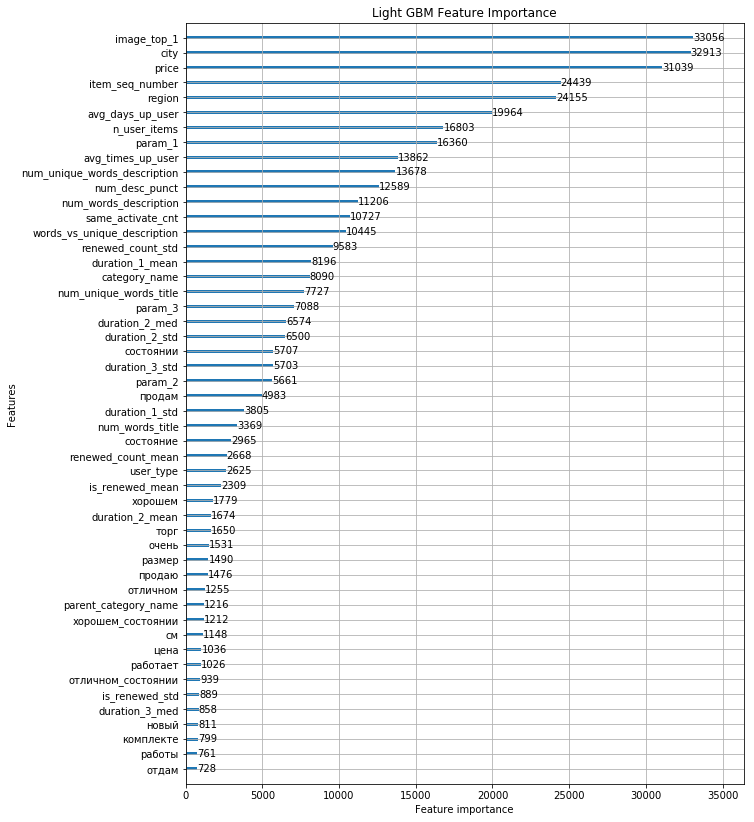

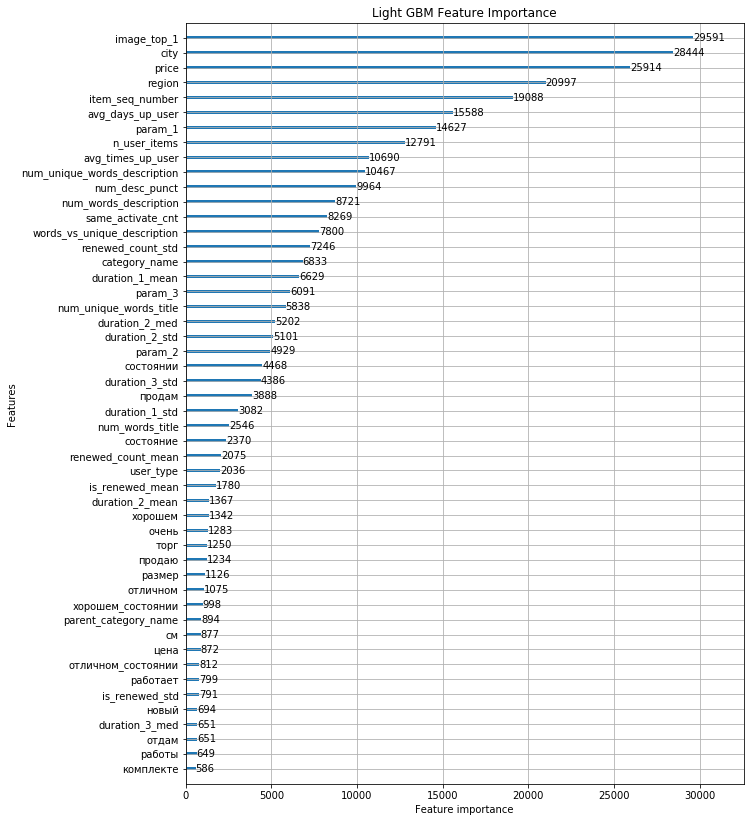

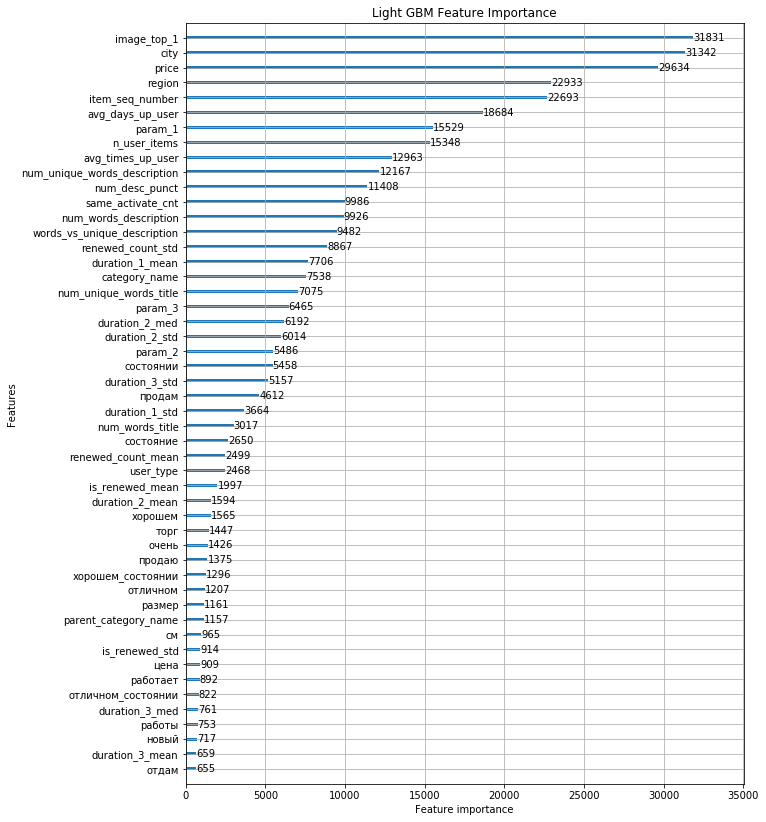

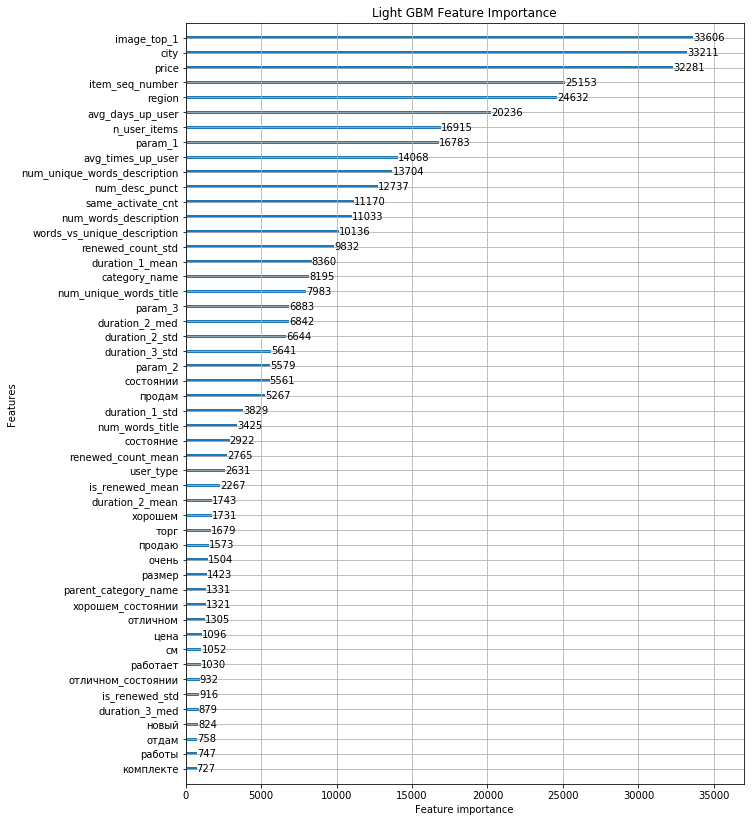

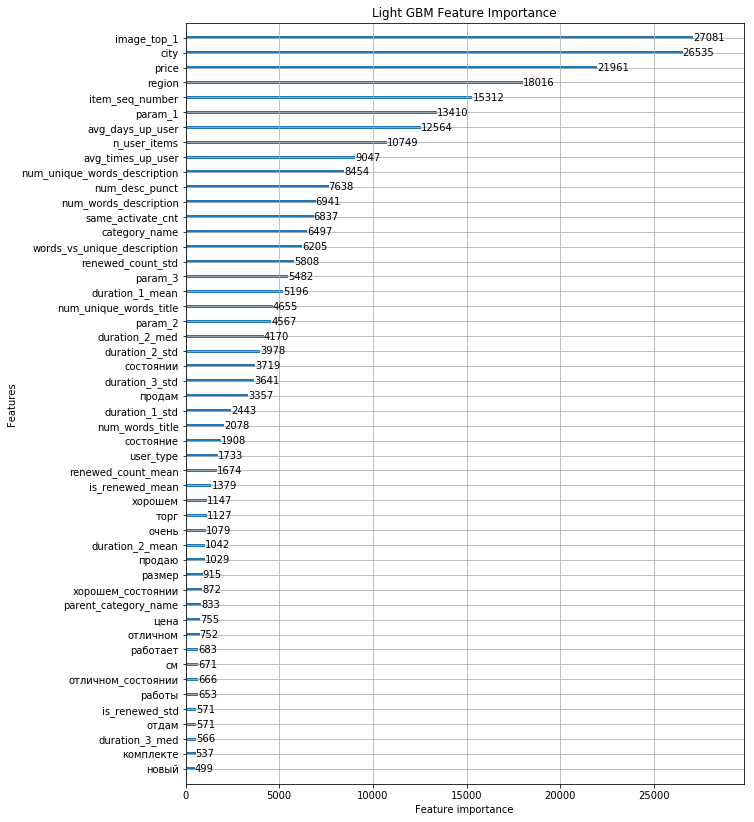

In [28]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [29]:
prefix = 'ad_period_'

In [30]:
pd.DataFrame(data=ret, columns=[prefix+'lgb_pred']).to_csv(prefix+'lgb_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=[prefix+'lgb_pred']).to_csv(prefix+'lgb_oof_test_pred.csv', index=False)

In [31]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv(prefix+'submission.csv', index=False)

In [32]:
import pickle
for md in ret_models:
    with open('models/'+prefix +'lgb.model', 'wb') as handle:
        pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
ret_test

array([ 0.34309741,  0.2081861 ,  0.27165165, ...,  0.14669958,
        0.36268476,  0.14775079])

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!